In [1]:
from torch_TICLNet import *
from helper_DataLoader import *

from IPython.display import clear_output
%matplotlib inline

# 1. Initialization

In [2]:
# load training dataset
testset = TICLNetDataset('../data/pickle/test.pkl')
# initialize a model
model = TICLNet()
model.load_state_dict(torch.load('../data/model/TICLNet.dict'))
model.eval()

TICLNet(
  (rnn): LayerSummarizeNet(
    (lstm1): LSTMCell(3, 20)
    (linear): Linear(in_features=20, out_features=16, bias=True)
  )
  (cnn): ClassifyNet(
    (conv): Sequential(
      (0): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
      (1): ReLU(inplace)
      (2): Conv1d(32, 32, kernel_size=(4,), stride=(2,))
      (3): ReLU(inplace)
      (4): Conv1d(32, 32, kernel_size=(4,), stride=(1,))
      (5): ReLU(inplace)
    )
    (fc): Sequential(
      (0): Linear(in_features=640, out_features=16, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=16, out_features=4, bias=True)
    )
  )
)

# 2. Testing

In [3]:
softmax = []
for i in range(len(testset)):
    event = testset[i]
    X = event["feature"]
    Y = event["label"]
    y = F.softmax(model(X),dim=1)
    softmax.append(y.data.numpy())
softmax = np.array(softmax)  
softmax = softmax.reshape(-1,4)

In [4]:
labels = np.array(testset.label)

# 3. Plot Result

In [5]:
predMatrix = np.zeros([4,4])

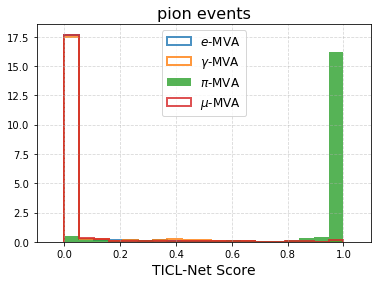

In [22]:
particle = 2
temp_softmax = softmax[labels==particle]

# prepare making plot
mvaBins = np.linspace(0,1,20)
mvaLabels = [r'$e$-MVA',r'$\gamma$-MVA',r'$\pi$-MVA',r'$\mu$-MVA']
particleName = ['electron','photon','pion','muon']

# make plot
plt.figure(facecolor='w')
for i in range(4):
    if i == particle:
        htype = 'stepfilled'
        halpha = 0.8
    else:
        htype = 'step'
        halpha = 0.8
    plt.hist(temp_softmax[:,i], mvaBins,
             normed=True,alpha = halpha,
             lw=2, histtype=htype,label=mvaLabels[i])
    
plt.legend(loc='upper center',fontsize=12)
plt.grid(linestyle='--',alpha=0.5)
plt.xlim(-0.1,1.1)
plt.xlabel('TICL-Net Score',fontsize=14)
plt.title('{} events'.format(particleName[particle]),fontsize=16)
plt.savefig('../plots/score/mva_{}.png'.format(particleName[particle]),dpi=200)

In [23]:
predicts = np.argmax(temp_softmax,axis=1)
h,b= np.histogram(predicts, bins=np.arange(5))
predMatrix[particle,:]=h/len(predicts)

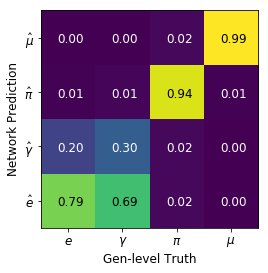

In [56]:
# show predicts
plt.figure(facecolor='w')
plt.imshow(predMatrix.T,origin='lower')
plt.xlabel('Gen-level Truth',fontsize=12)
plt.ylabel('Network Prediction',fontsize=12)
plt.xticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\pi$',r'$\mu$'],fontsize=12)
plt.yticks(np.arange(4),[r'$\hat{e}$',r'$\hat{\gamma}$',r'$\hat{\pi}$',r'$\hat{\mu}$'],fontsize=12)

for i in range(4):
    for j in range(4):
        clr = 'w'
        val = predMatrix[i,j]
        if val >0.5:
            clr = 'k'
        plt.text(i-0.2,j-0.1,'{:4.2f}'.format(val), color=clr,fontsize=12)

plt.savefig('../plots/score/accuracy.png',dpi=200)